Click [here](https://tensor4all.org/T4AJuliaTutorials/_sources/ipynbs/quantics1d.ipynb) to download the notebook locally.


# Quantics TCI of univariate function


In [1]:
using PythonCall: PythonCall
using PythonPlot: pyplot as plt, Figure

# Displays the matplotlib figure object `fig` and avoids duplicate plots.
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::PythonCall.Py) = _display(Figure(fig))

import QuanticsGrids as QG
using QuanticsTCI: quanticscrossinterpolate, integral

## Example 1

The first example is taken from Fig. 1 in [Ritter2024](https://arxiv.org/abs/2303.11819).

We are going to compute the integral $\mathrm{I}[f] = \int_0^{\ln 20} \mathrm{d}x f(x) $ of the function

$$
f(x) = \cos\left(\frac{x}{B}\right) \cos\left(\frac{x}{4\sqrt{5}B}\right) e^{-x^2} + 2e^{-x},
$$

where $B = 2^{-30}$.
The integral evaluates to $\mathrm{I}[f] = 19/10 + O(e^{-1/(4B^2)})$.

We first construct a QTT representation of the function $f(x)$ as follows:

In [2]:
B = 2^(-30) # global variable
function f(x)
    return cos(x / B) * cos(x / (4 * sqrt(5) * B)) * exp(-x^2) + 2 * exp(-x)
end

println(f(0.2))

1.7990930849034745


Let's examine the behaviour of $f(x)$. This function involves structure on widely different scales: rapid, incommensurate oscillations and a slowly decaying envelope. We'll use [PythonPlot.jl](https://github.com/JuliaPy/PythonPlot.jl) visualisation library which uses Python library [matplotlib](https://matplotlib.org/) behind the scenes.

For small $x$ we have:


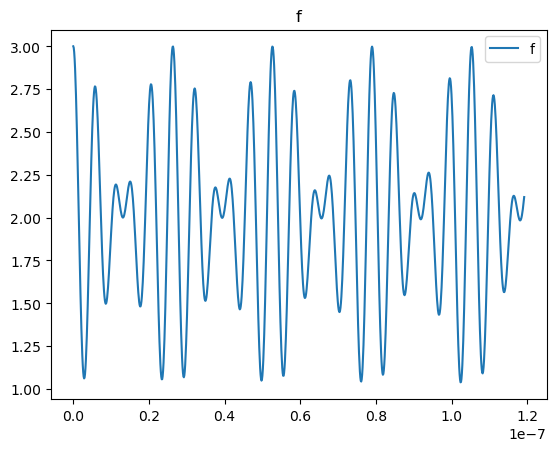

In [3]:
xs = LinRange(0, 2.0^(-23), 1000)

fig, ax = plt.subplots()
ax.plot(xs, f.(xs), label="$(nameof(f))")
ax.set_title("$(nameof(f))")
ax.legend()
_display(fig)

For $x \in (0, 3]$ we will get:


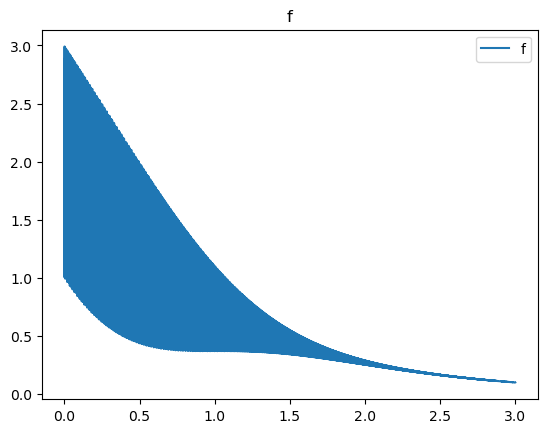

In [4]:
xs2 = LinRange(2.0^(-23), 3, 100000)
fig, ax = plt.subplots()
ax.plot(xs2, f.(xs2), label="$(nameof(f))")
ax.set_title("$(nameof(f))")
ax.legend()
_display(fig)

### QTT representation

We construct a QTT representation of this function on the domain $[0, \ln 20]$, discretized on a quantics grid of size $2^\mathcal{R}$ with $\mathcal{R} = 40$ bits:


In [5]:
R = 40 # number of bits
xmin = 0.0
xmax = log(20.)
N = 2^R # size of the grid
# * Uniform grid (includeendpoint=false, default):
#   -xmin, -xmin+dx, ...., -xmin + (2^R-1)*dx
#     where dx = (xmax - xmin)/2^R.
#   Note that the grid does not include the end point xmin.
#
# * Uniform grid (includeendpoint=true):
#   -xmin, -xmin+dx, ...., xmin-dx, xmin,
#     where dx = (xmax - xmin)/(2^R-1).
qgrid = QG.DiscretizedGrid{1}(R, xmin, xmax; includeendpoint=true)
ci, ranks, errors = quanticscrossinterpolate(Float64, f, qgrid; maxbonddim=15)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 15, QuanticsGrids.DiscretizedGrid{1}(40, (0.0,), (2.995732273553991,), 2, :fused, true), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 37350 entries), [15, 15, 15], [2.4042050801308078e-8, 2.6981942937595183e-8, 2.6239754927772822e-8])

In [6]:
length(ci.tci)

40

Here, we've created the object `ci` of type `QuanticsTensorCI2{Float64}`. This can be evaluated at an linear index $i$ ($1 \le i \le 2^\mathcal{R}$) as follows:


In [7]:
for i in [1, 2, 3, 2^R] # Linear indices
    # restore original coordinate `x` from linear index `i`
    x = QG.grididx_to_origcoord(qgrid, i)
    println("x: $(x), i: $(i), tci: $(ci(i)), ref: $(f(x))")
end

x: 0.0, i: 1, tci: 3.0, ref: 3.0
x: 2.724602630730001e-12, i: 2, tci: 2.999995667173124, ref: 2.999995667173124
x: 5.449205261460002e-12, i: 3, tci: 2.9999826687427715, ref: 2.9999826687427715
x: 2.995732273553991, i: 1099511627776, tci: 0.10000652437612735, ref: 0.1000065283433056


We see that `ci(i)` approximates the original `f` at `x = QG.grididx_to_origcoord(qgrid, i)`. Let's plot them together.


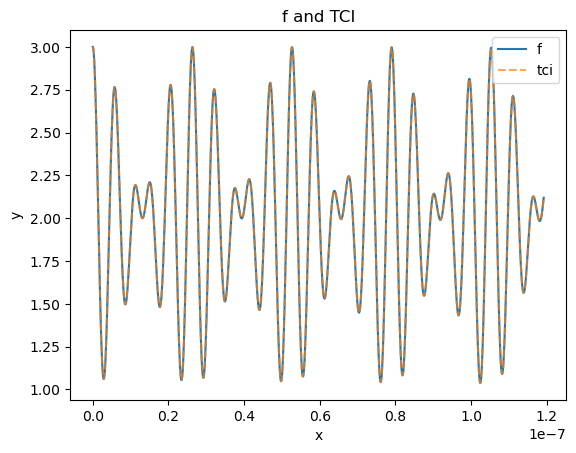

In [8]:
maxindex = QG.origcoord_to_grididx(qgrid, 2.0^(-23))
testindices = Int.(round.(LinRange(1, maxindex, 1000)))

xs = [QG.grididx_to_origcoord(qgrid, i) for i in testindices]
ys = f.(xs)
yci = ci.(testindices)

fig, ax = plt.subplots()
ax.plot(xs, ys, label="$(nameof(f))")
ax.plot(xs, yci, label="tci", linestyle="dashed", alpha=0.7)
ax.set_title("$(nameof(f)) and TCI")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
_display(fig)

Above, one can see that the original function is interpolated very accurately.

Let's plot of $x$ vs interpolation error $|f(x) - \mathrm{ci}(x)|$ for small $x$


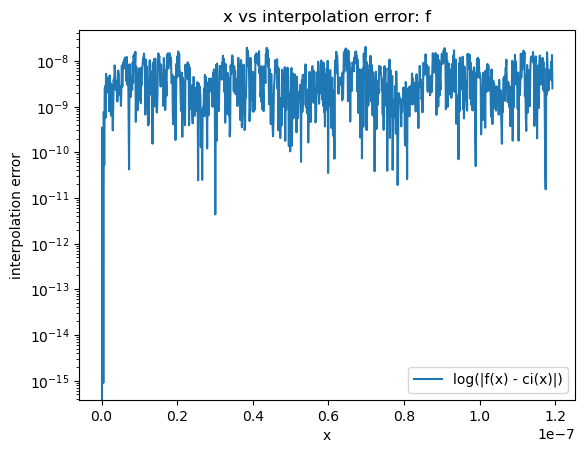

In [9]:
fig, ax = plt.subplots()

ys = f.(xs)
yci = ci.(testindices)

ax.semilogy(xs, abs.(ys .- yci), label="log(|f(x) - ci(x)|)")

ax.set_title("x vs interpolation error: $(nameof(f))")
ax.set_xlabel("x")
ax.set_ylabel("interpolation error")
ax.legend()
_display(fig)

... and for all $x$:

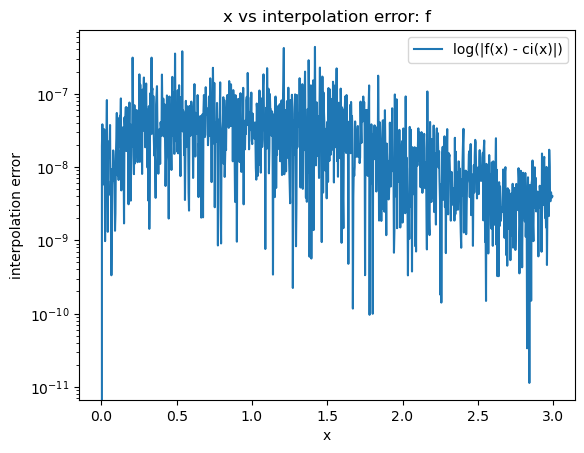

In [10]:
fig, ax = plt.subplots()

testindices = Int.(round.(LinRange(1, 2^R, 1000)))
xs = [QG.grididx_to_origcoord(qgrid, i) for i in testindices]
ys = f.(xs)
yci = ci.(testindices)

ax.semilogy(xs, abs.(ys .- yci), label="log(|f(x) - ci(x)|)")

ax.set_title("x vs interpolation error: $(nameof(f))")
ax.set_xlabel("x")
ax.set_ylabel("interpolation error")
ax.legend()
_display(fig)

The function is approximated with an accuracy $\approx 10^{-7}$ over the entire domain.

We are now ready to compute the integral $\mathrm{I}[f] = \int_0^{\ln 20} \mathrm{d}x f(x) \simeq 19/10$ using the QTT representation of $f(x)$.

In [11]:
integral(ci), 19/10

(1.900000003347911, 1.9)

`integral(ci)` is equivalent to calling `QuanticsTCI.sum(ci)` and multiplying the result by the interval length divided by $2^\mathcal{R}$.

In [12]:
sum(ci) * (log(20) - 0) / 2^R, 19/10

(1.900000003346183, 1.9)

### About `ci::QuanticsTensorCI2{Float64}`

Let's dive into the `ci` object:


In [13]:
println(typeof(ci))

QuanticsTCI.QuanticsTensorCI2{Float64}


As we've seen before, `ci` is an object of `QuanticsTensorCI2{Float64}` in `QuanticsTCI.jl`, which is a thin wrapper of `TensorCI2{Float64}` in `TensorCrossInterpolation.jl`.
The undering object of `TensorCI2{Float64}` type can be accessed as `ci.tci`. This will be useful for obtaining more detailed information on the TCI results.

For instance, `ci.tci.maxsamplevalue` is an estimate of the abosolute maximum value of the function, and `ci.tci.pivoterrors` stores the error as function of the bond dimension computed by prrLU.
In the following figure, we plot the normalized error vs. bond dimension, showing an exponential decay.


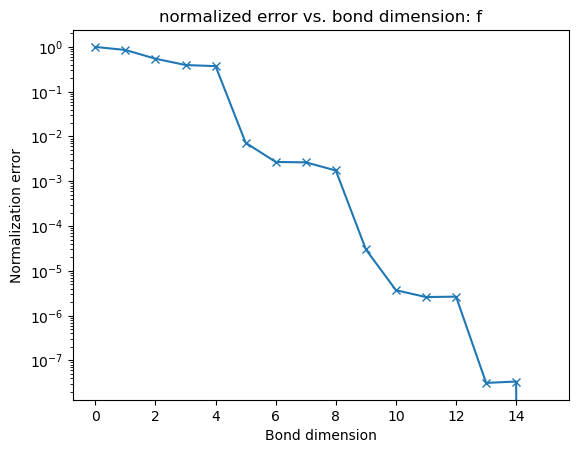

In [14]:
# Plot error vs bond dimension obtained by prrLU
fig, ax = plt.subplots()
ax.plot(ci.tci.pivoterrors ./ ci.tci.maxsamplevalue, marker="x")
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Normalization error")
ax.set_title("normalized error vs. bond dimension: $(nameof(f))")
ax.set_yscale("log")
_display(fig)

### Function evaluations

Our TCI algorithm does not call elements of the entire tensor, but constructs the TT (Tensor Train) from some elements chosen adaptively. On which points $x \in [0, 3]$ was the function evaluated to construct a QTT representation of the function $f(x)$? Let's find out. One can retrieve the information on the function evaluations as follows.


In [15]:
import QuanticsTCI
# Dict{Float64,Float64}
# key: `x`
# value: function value at `x`
evaluated = QuanticsTCI.cachedata(ci)

Dict{Float64, Float64} with 37350 entries:
  0.742511    => 0.602865
  0.733379    => 0.981137
  1.12046e-5  => 2.11592
  0.733254    => 0.913369
  0.718684    => 1.23321
  0.742408    => 1.44686
  0.707002    => 1.33421
  4.07308e-5  => 1.7639
  1.06132     => 0.651868
  1.26526e-6  => 2.08067
  0.742453    => 0.718994
  0.729286    => 0.567092
  0.0252318   => 2.14015
  0.0223984   => 1.97045
  0.709609    => 0.701381
  0.311656    => 1.62059
  0.000732853 => 2.13264
  0.721369    => 0.752363
  0.709633    => 1.4479
  0.707711    => 1.51198
  0.70699     => 1.17158
  0.0222522   => 2.16755
  0.719358    => 0.83591
  0.00112864  => 2.77647
  1.09999     => 0.518037
  ⋮           => ⋮

Let's plot `f` and the evaluated points together.


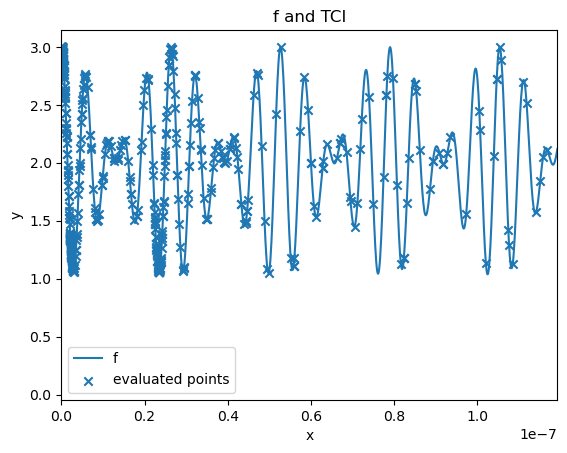

In [16]:
f̂(x) = ci(QG.origcoord_to_quantics(qgrid, x))
xs = LinRange(0, 2.0^(-23), 1000)

xs_evaluated = collect(keys(evaluated))
fs_evaluated = [evaluated[x] for x in xs_evaluated]

fig, ax = plt.subplots()
ax.plot(xs, f.(xs), label="$(nameof(f))")
ax.scatter(xs_evaluated, fs_evaluated, marker="x", label="evaluated points")
ax.set_title("$(nameof(f)) and TCI")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0, maximum(xs))
ax.legend()
_display(fig)

## Example 2

We now consider the function:

$$
\newcommand{\sinc}{\mathrm{sinc}}
\begin{align}
f(x) &= \sinc(x)+3e^{-0.3(x-4)^2}\sinc(x-4) \nonumber\\
&\quad - \cos(4x)^2-2\sinc(x+10)e^{-0.6(x+9)} + 4 \cos(2x) e^{-|x+5|}\nonumber \\
&\quad +\frac{6}{x-11}+ \sqrt{(|x|)}\arctan(x/15).\nonumber
\end{align}
$$

One can construct a QTT representation of this function on the domain $[-10, 10]$ using a quantics grid of size $2^\mathcal{R}$ ($\mathcal{R}=20$):


In [17]:
import QuanticsGrids as QG
using QuanticsTCI

R = 20 # number of bits
N = 2^R  # size of the grid

qgrid = QG.DiscretizedGrid{1}(R, -10, 10; includeendpoint=false)

# Function of interest
function oscillation_fn(x)
    return (
        sinc(x) + 3 * exp(-0.3 * (x - 4)^2) * sinc(x - 4) - cos(4 * x)^2 -
        2 * sinc(x + 10) * exp(-0.6 * (x + 9)) + 4 * cos(2 * x) * exp(-abs(x + 5)) +
        6 * 1 / (x - 11) + sqrt(abs(x)) * atan(x / 15))
end

# Convert to quantics format and sweep
ci, ranks, errors = quanticscrossinterpolate(Float64, oscillation_fn, qgrid; maxbonddim=15)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 14, QuanticsGrids.DiscretizedGrid{1}(20, (-10.0,), (10.0,), 2, :fused, false), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 2894 entries), [13, 14, 14, 14], [9.689610129499596e-9, 8.013103117106305e-9, 8.013103117106305e-9, 8.013103117106305e-9])

In [18]:
for i in [1, 2, 2^R] # Linear indices
    x = QG.grididx_to_origcoord(qgrid, i)
    println("x: $(x), tci: $(ci(i)), ref: $(oscillation_fn(x))")
end

x: -10.0, tci: -6.223187220679993, ref: -6.223187220679993
x: -9.999980926513672, tci: -6.223066148054395, ref: -6.223066148054395
x: 9.999980926513672, tci: -4.585194580210248, ref: -4.585194580210247


Above, one can see that the original function is interpolated very accurately. The function `grididx_to_origcoord` transforms a linear index to a coordinate point $x$ in the original domain ($-10 \le x < 10$).

In the following figure, we plot the normalized error vs. bond dimension, showing an exponential decay.


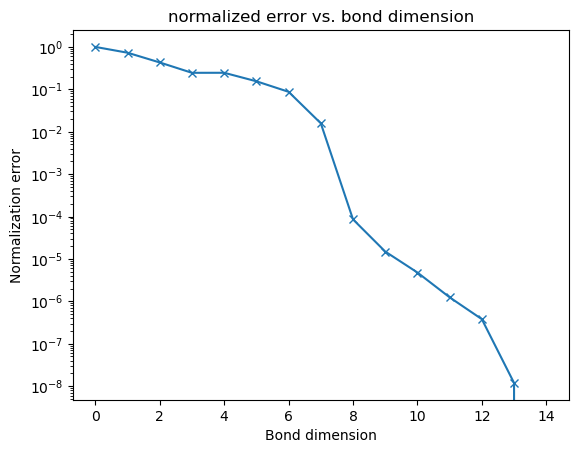

In [19]:
# Plot error vs bond dimension obtained by prrLU
using PythonPlot: pyplot as plt, gcf

fig, ax = plt.subplots()
ax.plot(ci.tci.pivoterrors ./ ci.tci.maxsamplevalue, marker="x")
ax.set_xlabel("Bond dimension")
ax.set_ylabel("Normalization error")
ax.set_title("normalized error vs. bond dimension")
ax.set_yscale("log")
_display(fig)

## Example 3

### Control the error of the TCI by a tolerance

We interpolate the same function as in Example 2, but this time we use a tolerance to control the error of the TCI. The tolerance is a positive number that determines the maximum error of the TCI, which is scaled by an estimate of the abosolute maximum of the function.
The TCI algorithm will adaptively increase the bond dimension until the error is below the tolerance.

In [20]:
tol = 1e-8 # Tolerance for the error

# Convert to quantics format and sweep
ci_tol, ranks_tol, errors_tol = quanticscrossinterpolate(
    Float64, oscillation_fn, qgrid;
    tolerance=tol,
    normalizeerror=true, # Normalize the error by the maximum sample value,
    verbosity=1, loginterval=1, # Log the error every `loginterval` iterations
    )

iteration = 1, rank = 13, error= 6.210103957327599e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=5
  Rejected 5 global pivots added in the previous iteration, errors are [1.1778362396519526e-8, 3.829813799427484e-9, 1.548038031096155e-9, 3.1216249238297245e-9, 1.2644555624774512e-8]
iteration = 2, rank = 14, error= 4.997221278790914e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0
iteration = 3, rank = 14, error= 4.449599701880746e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0
iteration = 4, rank = 14, error= 4.449599701880746e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0


  Rejected 5 global pivots added in the previous iteration, errors are [1.1778362396519526e-8, 3.829813799427484e-9, 1.548038031096155e-9, 3.1216249238297245e-9, 1.2644555624774512e-8]


iteration = 2, rank = 14, error= 4.997221278790914e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0


iteration = 3, rank = 14, error= 4.449599701880746e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0


iteration = 4, rank = 14, error= 4.449599701880746e-8, maxsamplevalue= 6.223187220679993, nglobalpivot=0


(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 14, QuanticsGrids.DiscretizedGrid{1}(20, (-10.0,), (10.0,), 2, :fused, false), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 3846 entries), [13, 14, 14, 14], [9.978976587255936e-9, 8.030003118313512e-9, 7.150033486208613e-9, 7.150033486208613e-9])

In [21]:
println("Max abs sampled value is $(ci_tol.tci.maxsamplevalue)")

Max abs sampled value is 6.223187220679993


In [22]:
errors_tol ./ ci_tol.tci.maxsamplevalue

4-element Vector{Float64}:
 1.6035154067188031e-9
 1.290336098459222e-9
 1.1489343374482868e-9
 1.1489343374482868e-9

### Estimate the error of the TCI
Wait!
Since we did not sample the function over the entire domain, we do not know the true error of the TCI.
In theory, we can estimate the error of the TCI by comparing the function values at the sampled points with the TCI values at the same points.
But, it is not practical to compare the function values with the TCI values at all points in the domain.
The function `estimatetrueerror` in `TensorCrossInterpolation.jl` provides a good estimate of the error of the TCI.
The algorithm finds indices (points) where the error is large by a randomized global search algorithm starting with a set of random initial points.

In [23]:
import TensorCrossInterpolation as TCI
pivoterror_global = TCI.estimatetrueerror(TCI.TensorTrain(ci.tci), ci.quanticsfunction; nsearch=100) # Results are sorted in descending order of the error

84-element Vector{Tuple{Vector{Int64}, Float64}}:
 ([1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1], 9.485916097062841e-8)
 ([1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1], 9.080223239976704e-8)
 ([1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2], 9.07497026414461e-8)
 ([1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2], 9.060585703934976e-8)
 ([1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2], 8.984344690432522e-8)
 ([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1], 8.960431419069437e-8)
 ([1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2], 8.956680552785201e-8)
 ([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2], 8.947060603503587e-8)
 ([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1], 8.944369067620528e-8)
 ([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2], 8.602606893504117e-8)
 ([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2], 8.489960556801179e-8)
 ([1,

Now, you can see the error estimate of the TCI is below the tolerance of $10^{-8}$ (or close to it).

In [24]:
println("The largest error found is $(pivoterror_global[1][2]) and the corresponding pivot is $(pivoterror_global[1][1]).")
println("The tolerance used is $(tol * ci_tol.tci.maxsamplevalue).")

The largest error found is 9.485916097062841e-8 and the corresponding pivot is [1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1].
The tolerance used is 6.223187220679993e-8.
